## Interest Rate Models_Assignment 4
### Weihao Li & Xinlu Xiao
### Contact Information: WEIHAO.LI@baruchmail.cuny.edu & xinluxiao.baruch@gmail.com

### Problem1

In [1]:
from math import *
from scipy.stats import norm
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
# normal option model

def normal_option(K,F , T,sigma, optiontype):
    '''
    calculate the option value under the normal model
    '''
    d = (F-K)/(sigma*sqrt(T))
    if optiontype == "call":
        optionvalue = sigma*sqrt(T)*(d*norm.cdf(d)+norm.pdf(d))
    elif optiontype == "put":
        optionvalue = sigma*sqrt(T)*(-d*norm.cdf(-d)+norm.pdf(-d))
    return optionvalue

In [3]:
# lognormal option model

def lognormal_option(F, K, T,sigma, optiontype):
    '''
    calculate the option value under lognormal model
    '''
    d1 = (log(F/K)+0.5*sigma**2*T)/(sigma*sqrt(T))
    d2 = (log(F/K)-0.5*sigma**2*T)/(sigma*sqrt(T))
    if optiontype == "call":
        optionvalue = norm.cdf(d1)*F-norm.cdf(d2)*K
    elif optiontype == "put":
        optionvalue = norm.cdf(-d2)*K - norm.cdf(-d1)*F
    return optionvalue

### Problem2

In [4]:
# convert volatility

def vol_convert(F,K,T,log_vol,ini_guess,optiontype):
    '''
    convert lognormal volatility to normal volatility
    '''
    price = lognormal_option(F, K, T,log_vol,optiontype)
    norm_sigma = opt.root(lambda sigma:normal_option(K, F, T,sigma, optiontype)-price,ini_guess).x[0]
    return norm_sigma   

### Problem3

In [5]:
def SABR(K,F0,sigma0,alpha,beta,rho):
    '''
    calculate SABR implied normal volatility
    '''
    if abs(F0/K-1)>0.001: 
        
        a = alpha*(F0**(1-beta)-K**(1-beta))/(sigma0*(1-beta))
        D = log((sqrt(1-2*rho*a+a**2)+a-rho)/(1-rho))
        implied_vol = alpha*(F0-K)/D
    else: # ATM
        implied_vol = sigma0*K**beta
    return implied_vol

### Problem4

In [6]:
# read excel data

implied_vols = pd.read_excel('SwaptionVolData.xls', skiprows = 4, parse_cols = 'B:O')[:6]
maturities = pd.read_excel('SwaptionVolData.xls', skiprpws = 4, parse_cols = 'B')[:7][1:].rename(columns={'Implied volatilities for 10 year tails':'mat'})
bps = pd.DataFrame(implied_vols.columns[1:]).rename(columns={0:'bps'}).set_value(6,'bps',0)
Fs = pd.read_excel('SwaptionVolData.xls', skiprows = 16, parse_cols = 'B:C')[:23]

In [7]:
implied_vols

,Mat yrs / bp out,-250,-200,-150,-100,-50,-25,ATM,25,50,100,150,200,250
0,0.25,0.486878,0.417007,0.375898,0.353496,0.344272,0.343122,0.343581,0.345218,0.347689,0.354141,0.361550,0.369199,0.376732
1,0.5,0.453976,0.397482,0.362891,0.342512,0.332046,0.329489,0.328249,0.328036,0.328606,0.331358,0.335390,0.340045,0.344944
2,1,0.411018,0.367114,0.338338,0.319918,0.309021,0.305706,0.303502,0.302205,0.301639,0.302126,0.304053,0.306823,0.310057
3,2,0.363079,0.330487,0.307374,0.291431,0.281125,0.277679,0.275171,0.273463,0.272424,0.271913,0.272886,0.274806,0.277303
4,3,0.330425,0.302629,0.281758,0.266502,0.255963,0.252209,0.249329,0.247219,0.245777,0.244512,0.244850,0.246259,0.248354
5,5,0.296923,0.273310,0.254509,0.239883,0.229024,0.224889,0.221545,0.218926,0.216963,0.214705,0.214185,0.214891,0.216419


In [8]:
maturities

,mat
1,0.25
2,0.5
3,1
4,2
5,3
6,5


In [9]:
maturities.get_value(1,'mat')

0.25

In [10]:
bps

,bps
0,-250
1,-200
2,-150
3,-100
4,-50
5,-25
6,0
7,25
8,50
9,100


In [11]:
Fs

,Mat yrs,Rate
0,0.25,0.035099
1,0.50,0.036323
2,1.00,0.038724
3,2.00,0.043129
4,3.00,0.046569
5,5.00,0.050303


In [12]:
# convert lognormal vol in excel to normal vol, and save it into dictionary

array_ivs = []
for m in range(len(implied_vols)):
    columns = []
    for k in range(len(bps)):
        
        F = Fs['Rate'][m]
        K = Fs['Rate'][m]+bps['bps'][k]*1e-4
        T = float(maturities.get_value(m+1,'mat'))
        columns.append(vol_convert(F,K,T,implied_vols.iloc[m][k+1],0.3,"call"))
    array_ivs.append(columns)

In [13]:
# cost function

def obj(OL):
    '''
    define calibration cost function by minimizing the sum of square
    '''
    sigma = OL[0]
    alpha = OL[1]
    rho = OL[2]
    
    # optimization goal function
    goal = 0
    for k in range(len(bps)):
        F = Fs['Rate'][m]
        K = Fs['Rate'][m]+bps['bps'][k]*1e-4
        T = float(maturities.get_value(m+1,'mat'))
        goal += (SABR(K,F,sigma,alpha,0.5,rho) -array_ivs[m][k])**2    
    return goal

In [14]:
# initial guess and calibration
ans = {}
for m in range(len(implied_vols)):
    OL = [0.1,0.3,0.0]
    ans[maturities.get_value(m+1,'mat')] = opt.fmin_bfgs(obj,OL,epsilon = 1e-9,gtol = 1e-9)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 195
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 200
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 200
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 190
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 28
         Function evaluations: 170
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 

In [15]:
# different set of parameter on time dimentions

df = pd.DataFrame(ans).T
df.columns = ['sigma','alpha','rho']
df

,sigma,alpha,rho
0.25,0.064299,0.545803,0.372079
0.50,0.062433,0.464835,0.311382
1.00,0.059514,0.412703,0.241624
2.00,0.056810,0.392662,0.173494
3.00,0.053415,0.384050,0.095244
5.00,0.049216,0.366039,-0.002380


### Problem5

Algorithm:

Generate two standard normal series $z_{1}$ and $z_{2}$:

$$ x = z_{1} $$
$$ y = \rho z_{1} + \sqrt{1-\rho^2}z_{2}$$

Thus the correlation between $x$ and $y$ is $\rho$.

In [19]:
# generate two dimensional Gaussian random numbers with correlation rho
# We construct a new pair of correlated random variable using choleskey decomposition of the correlation matrix cov =[[1,rho][rho,h]] 
def generate_correlated(num, rho):
    z1 = np.random.normal(size = num)
    z2 = np.random.normal(size = num)
    x = z1
    y = rho*z1 + sqrt(1- rho**2)*z2
    return x,y

In [20]:
# set the correlation as -0.2 and test it with numpy package
test = generate_correlated(10000000,-0.2) 
print(np.corrcoef(test[0],test[1]))

[[ 1.         -0.19985104]
 [-0.19985104  1.        ]]


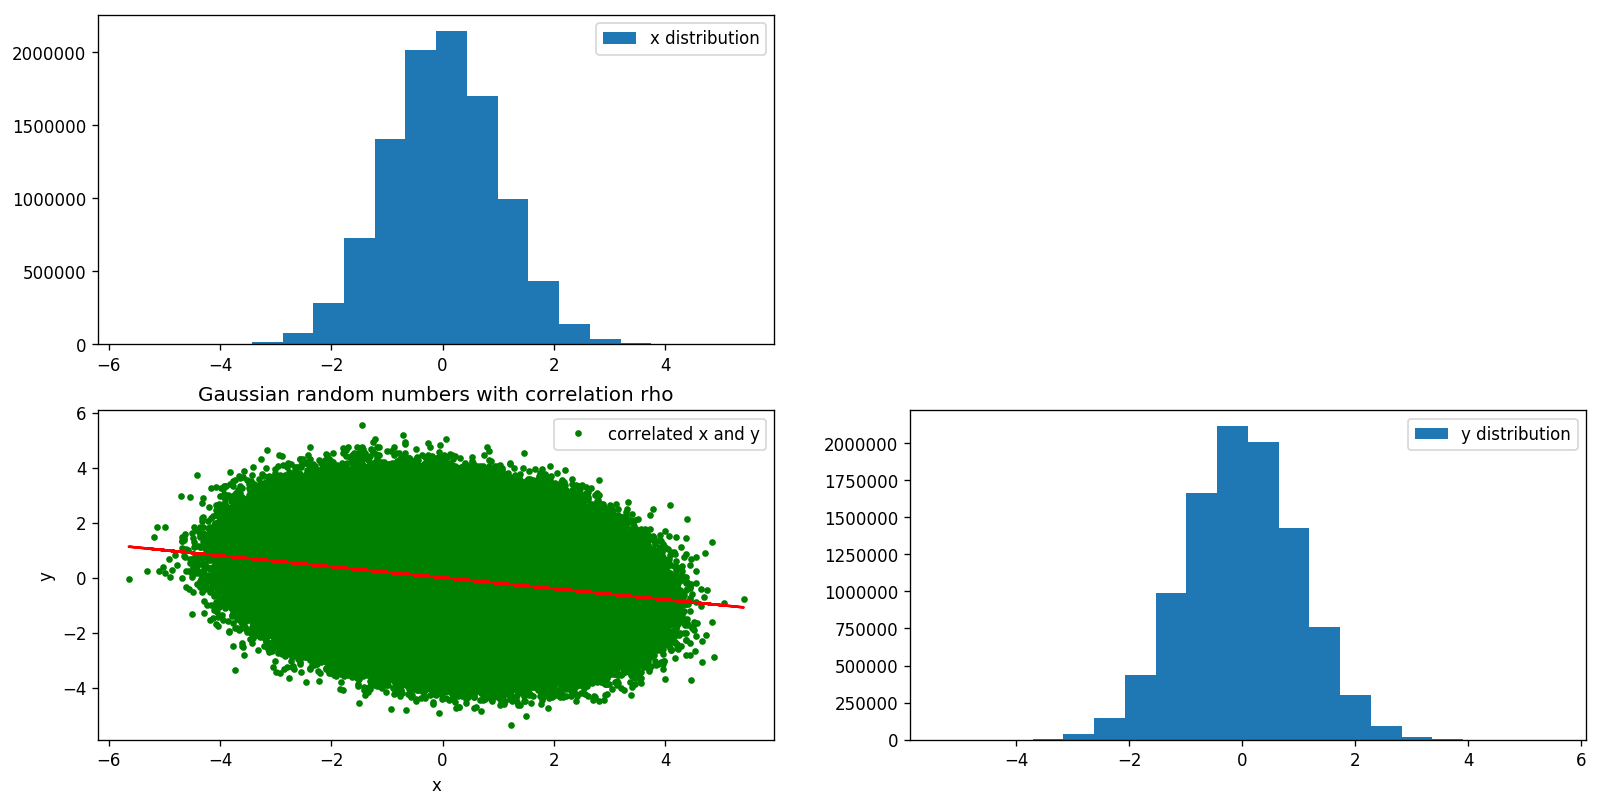

In [24]:
plt.figure(figsize=(16,8),dpi= 120)

plt.subplot(2,2,1)
plt.hist(test[0], bins = 20,label='x distribution')
plt.legend()

plt.subplot(2,2,3)
plt.title('Gaussian random numbers with correlation rho')
m,b = np.polyfit(test[0],test[1],1)
plt.plot(test[0],test[1],'b.',color = 'green',label = 'correlated x and y')
plt.plot(test[0],m*test[0]+b,'-',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(2,2,4)
plt.hist(test[1], bins = 20,label='y distribution')
plt.legend()

### Problem6

In [25]:
# generate MC path for SABR model

def MC_SABR(K,F0, sigma0, alpha,beta,rho,optiontype,T,num,times):
    '''
    num: discretization num for one path
    times: num of paths
    rho: correlation
    '''
    num = int(num)
    delta_t = float(T)/float(num)
    option_values = np.array([])
    for k in range(times):
        sigma = sigma0
        F = F0
        test = generate_correlated(num, rho)
        
        x = test[0]
        y = test[1]
        for i in range(num):      
            F = max(F+sigma*F**(beta)*sqrt(delta_t)*x[i],0)
            sigma = sigma*exp(alpha*sqrt(delta_t)*y[i]-alpha**2*delta_t/2)
        if optiontype == "call":
            option_values = np.append(option_values,max(F-K,0))
        elif optiontype == "put":
            option_values = np.append(option_values,max(K-F,0))            
    result = np.average(option_values)
    
    return option_values,result    

### Problem7

In [27]:
# read given parameters

sabr = pd.read_excel('sabr.xlsx', skiprows = 1, parse_cols = 'A:H')[:22].rename(columns = {'Unnamed: 0':'type'})

In [28]:
sabr

,type,T,F0,K,sigma0,alpha,beta,rho
0,call,0.25,0.005,0.010,0.0072,1.1,0.2,0.8
1,call,0.25,0.050,0.060,0.0224,0.8,0.5,-0.2
2,call,0.50,0.010,0.020,0.0400,0.8,0.5,0.7
3,call,0.50,0.050,0.060,0.0182,0.7,0.2,-0.3
4,call,1.00,0.015,0.020,0.0232,0.6,0.2,0.4
5,call,1.00,0.040,0.050,0.0500,0.5,0.5,-0.3
6,call,2.00,0.020,0.030,0.0707,0.5,0.5,0.3
7,call,2.00,0.060,0.070,0.0176,0.5,0.2,-0.1
8,call,5.00,0.050,0.060,0.0146,0.4,0.2,0.2
9,call,5.00,0.050,0.070,0.0447,0.3,0.5,-0.5


In [29]:
# evalueate options with MC  

def option_valuation(sabr,num,times):
    values = np.array([])
    for i in range(len(sabr)):
        #(K,F0, sigma0, alpha,beta,rho,optiontype,T,num,times)
        value = MC_SABR(sabr['K'][i],
                        sabr['F0'][i],
                        sabr['sigma0'][i],
                        sabr['alpha'][i],
                        sabr['beta'][i],
                        sabr['rho'][i],
                        sabr['type'][i],
                        sabr['T'][i],
                        num,times)[1]
                         
        values = np.append(values, value)
    return values

In [30]:
#run the simulations for 5000 paths and discretized each path to 100 parts
sabr['MC value'] =  pd.DataFrame(option_valuation(sabr,100,5000))   

In [46]:
def compare(sabr):
    implied_vols = np.array([])
    black_values = np.array([])
    differences = np.array([])
    for i in range(len(sabr)):
        vol = SABR(sabr['K'][i],
                        sabr['F0'][i],
                        sabr['sigma0'][i],
                        sabr['alpha'][i],
                        sabr['beta'][i],
                        sabr['rho'][i])
        black_value = normal_option(sabr['K'][i],sabr['F0'][i], sabr['T'][i],
                                    vol, sabr['type'][i])
        diff = black_value - sabr['MC value'][i] 
        implied_vols = np.append(implied_vols, vol)
        black_values = np.append(black_values, black_value)
        differences = np.append(differences, diff)
    return implied_vols,black_values,differences
        

In [47]:
# save the output to dataframe

compare_result = compare(sabr)
sabr['implied_vol'] = pd.DataFrame(compare_result[0])
sabr['black values'] = pd.DataFrame(compare_result[1])
sabr['difference'] = pd.DataFrame(compare_result[2])

In [48]:
sabr

,type,T,F0,K,sigma0,alpha,beta,rho,MC value,implied_vol,black values,difference
0,call,0.25,0.005,0.010,0.0072,1.1,0.2,0.8,1.533442e-05,0.004738,1.488520e-05,-4.492176e-07
1,call,0.25,0.050,0.060,0.0224,0.8,0.5,-0.2,9.079342e-07,0.006096,4.170840e-07,-4.908502e-07
2,call,0.50,0.010,0.020,0.0400,0.8,0.5,0.7,5.886419e-05,0.007677,6.965548e-05,1.079129e-05
3,call,0.50,0.050,0.060,0.0182,0.7,0.2,-0.3,2.639953e-04,0.009928,2.438980e-04,-2.009725e-05
4,call,1.00,0.015,0.020,0.0232,0.6,0.2,0.4,2.301791e-03,0.011015,2.339519e-03,3.772879e-05
5,call,1.00,0.040,0.050,0.0500,0.5,0.5,-0.3,8.637984e-04,0.010225,8.881789e-04,2.438049e-05
6,call,2.00,0.020,0.030,0.0707,0.5,0.5,0.3,2.840639e-03,0.012136,2.977640e-03,1.370009e-04
7,call,2.00,0.060,0.070,0.0176,0.5,0.2,-0.1,2.422718e-03,0.010336,2.145450e-03,-2.772679e-04
8,call,5.00,0.050,0.060,0.0146,0.4,0.2,0.2,4.236318e-03,0.008830,3.866110e-03,-3.702077e-04
9,call,5.00,0.050,0.070,0.0447,0.3,0.5,-0.5,2.155886e-03,0.009886,2.201007e-03,4.512029e-05


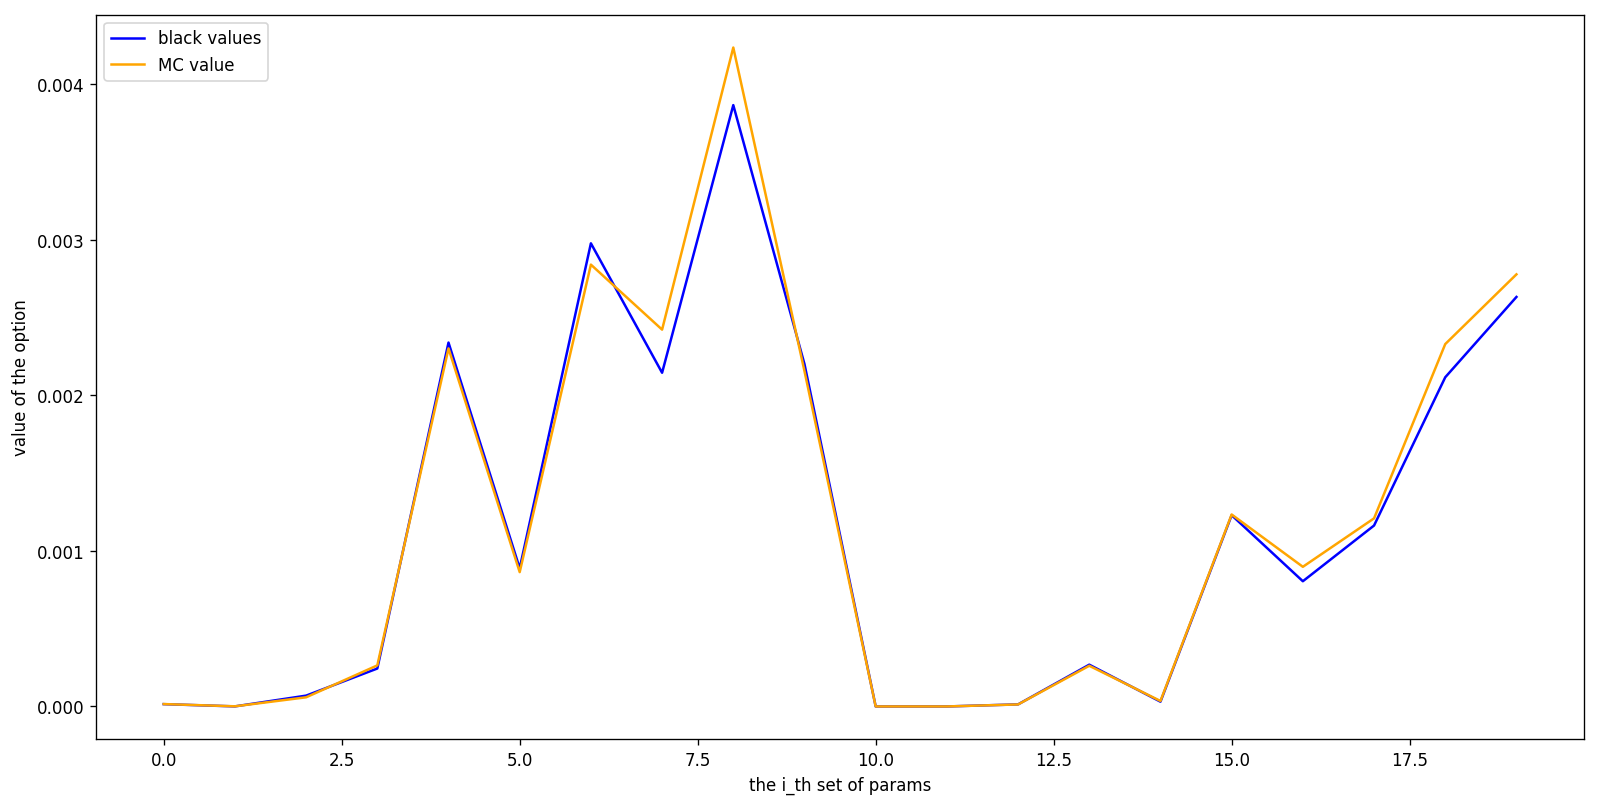

In [49]:
# plot the results

plt.figure(figsize=(16,8),dpi= 120)
plt.plot(sabr['black values'],c = 'blue',label = 'black values')
plt.plot(sabr['MC value'],c='orange',label = 'MC value')
plt.legend(loc='upper left')
plt.ylabel("value of the option")
plt.xlabel("the i_th set of params")